# MAnet

## Install & Import Dependencies

In [1]:
%pip install -q git+https://github.com/PyTorchLightning/pytorch-lightning
%pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
%pip install -q git+https://github.com/albumentations-team/albumentations
%pip install -q torchinfo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torch import nn
from tqdm.notebook import tqdm

## Extract Data

In [2]:
IMAGE_SIZE = 320
BATCH_SIZE = 4
EPOCHS = 20

color_dict = pd.read_csv('../deepglobe-land-cover-classification-dataset/class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [3]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("../deepglobe-land-cover-classification-dataset/train/*.jpg")), 
    'MASKS': sorted(glob("../deepglobe-land-cover-classification-dataset/train/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

IMAGES  \
0  ../deepglobe-land-cover-classification-dataset...   
1  ../deepglobe-land-cover-classification-dataset...   
2  ../deepglobe-land-cover-classification-dataset...   
3  ../deepglobe-land-cover-classification-dataset...   
4  ../deepglobe-land-cover-classification-dataset...   

                                               MASKS  
0  ../deepglobe-land-cover-classification-dataset...  
1  ../deepglobe-land-cover-classification-dataset...  
2  ../deepglobe-land-cover-classification-dataset...  
3  ../deepglobe-land-cover-classification-dataset...  
4  ../deepglobe-land-cover-classification-dataset...

In [4]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(pd_dataset, test_size=0.25, random_state=0)
pd_train, pd_val = train_test_split(pd_train, test_size=0.2, random_state=0)

print("Training set size:", len(pd_train))
print("Validation set size:", len(pd_val))
print("Testing set size:", len(pd_test))

Training set size: 481
Validation set size: 121
Testing set size: 201


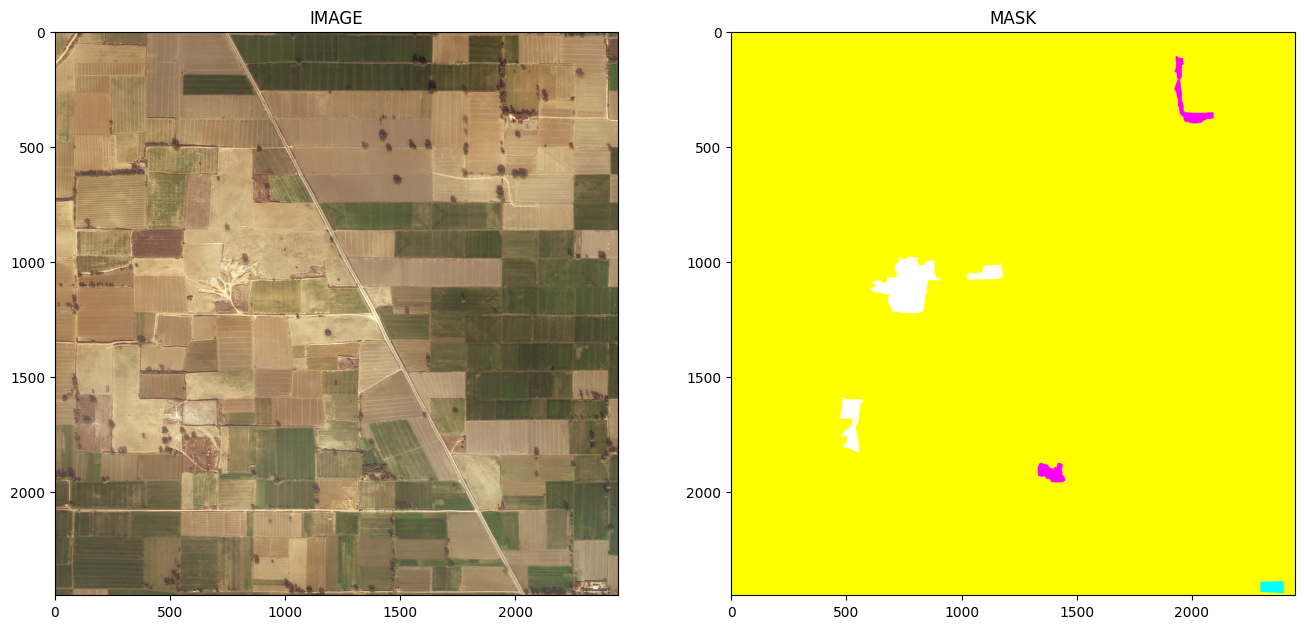

In [5]:
index = 200

sample_img = cv2.imread(pd_train.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_train.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

## Utility Functions

In [6]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

## Data Augmentations & Transformations

In [7]:
import albumentations as aug

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomBrightnessContrast(p=0.3)
])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])

## Create PyTorch Dataset

In [8]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.MASKS)
        mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        
        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask

In [9]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.pd_train, train_augment)
        self.val_dataset = SegmentationDataset(self.pd_val, test_augment)
        self.test_dataset = SegmentationDataset(self.pd_test, test_augment)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size // 2, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size // 2, shuffle=False)

In [10]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

In [11]:
image, mask = next(iter(data_module.train_dataloader()))
image.shape, mask.shape

(torch.Size([4, 3, 320, 320]), torch.Size([4, 1, 320, 320]))

## Build Loss and Model

In [12]:
from segmentation_models_pytorch import MAnet
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score

class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MAnet(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=3,
            classes=len(CLASSES),
            activation=None
        )
        self.criterion = DiceLoss(mode="multiclass", from_logits=False)
    
    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

c:\Users\GlowingMan\miniconda3\envs\py3_10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
from torchinfo import summary

model = SegmentationModel()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                                  Output Shape              Param #
SegmentationModel                                       [4, 7, 320, 320]          --
├─MAnet: 1-1                                            [4, 7, 320, 320]          --
│    └─ResNetEncoder: 2-1                               [4, 3, 320, 320]          --
│    │    └─Conv2d: 3-1                                 [4, 64, 160, 160]         9,408
│    │    └─BatchNorm2d: 3-2                            [4, 64, 160, 160]         128
│    │    └─ReLU: 3-3                                   [4, 64, 160, 160]         --
│    │    └─MaxPool2d: 3-4                              [4, 64, 80, 80]           --
│    │    └─Sequential: 3-5                             [4, 256, 80, 80]          215,808
│    │    └─Sequential: 3-6                             [4, 512, 40, 40]          1,219,584
│    │    └─Sequential: 3-7                             [4, 1024, 20, 20]         7,098,368
│    │    └─Sequential: 3-8          

## Train the Model

In [14]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="manet-checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="manet-log")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model, data_module)

Missing logger folder: lightning_logs\manet-log
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | model     | MAnet    | 147 M 
1 | criterion | DiceLoss | 0     
---------------------------------------
147 M     Trainable params
0         Non-trainable params
147 M     Total params
589.763   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\GlowingMan\miniconda3\envs\py3_10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s]

c:\Users\GlowingMan\miniconda3\envs\py3_10\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


c:\Users\GlowingMan\miniconda3\envs\py3_10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 121/121 [08:59<00:00,  0.22it/s, v_num=0, val/Loss=-8.4e+6, val/IoU=0.152, val/Accuracy=0.783, val/Precision=0.242, val/Recall=0.242, val/F1score=0.242, train/Loss=-5.07e+7, train/IoU=0.0804, train/Accuracy=0.756, train/Precision=0.147, train/Recall=0.147, train/F1score=0.147]

Epoch 0, global step 121: 'val/F1score' reached 0.24183 (best 0.24183), saving model to 'F:\\GitHub Repos\\crop-field-segmentation\\individual_models\\manet-checkpoints\\best-checkpoint.ckpt' as top 1


Epoch 1: 100%|██████████| 121/121 [07:12<00:00,  0.28it/s, v_num=0, val/Loss=-7.72e+6, val/IoU=0.206, val/Accuracy=0.804, val/Precision=0.314, val/Recall=0.314, val/F1score=0.314, train/Loss=-2.24e+8, train/IoU=0.157, train/Accuracy=0.790, train/Precision=0.265, train/Recall=0.265, train/F1score=0.265] 

Epoch 1, global step 242: 'val/F1score' was not in top 1


Epoch 2: 100%|██████████| 121/121 [06:46<00:00,  0.30it/s, v_num=0, val/Loss=-1.15e+7, val/IoU=0.238, val/Accuracy=0.814, val/Precision=0.349, val/Recall=0.349, val/F1score=0.349, train/Loss=-4.69e+8, train/IoU=0.218, train/Accuracy=0.814, train/Precision=0.348, train/Recall=0.348, train/F1score=0.348]

Epoch 2, global step 363: 'val/F1score' was not in top 1


Epoch 3: 100%|██████████| 121/121 [07:27<00:00,  0.27it/s, v_num=0, val/Loss=-2.93e+7, val/IoU=0.362, val/Accuracy=0.859, val/Precision=0.507, val/Recall=0.507, val/F1score=0.507, train/Loss=-6.03e+8, train/IoU=0.298, train/Accuracy=0.841, train/Precision=0.445, train/Recall=0.445, train/F1score=0.445]

Epoch 3, global step 484: 'val/F1score' was not in top 1


Epoch 4: 100%|██████████| 121/121 [05:44<00:00,  0.35it/s, v_num=0, val/Loss=-5.06e+6, val/IoU=0.533, val/Accuracy=0.906, val/Precision=0.670, val/Recall=0.670, val/F1score=0.670, train/Loss=-2.86e+8, train/IoU=0.420, train/Accuracy=0.880, train/Precision=0.579, train/Recall=0.579, train/F1score=0.579]

Epoch 4, global step 605: 'val/F1score' was not in top 1


Epoch 5: 100%|██████████| 121/121 [06:17<00:00,  0.32it/s, v_num=0, val/Loss=-4.18e+7, val/IoU=0.578, val/Accuracy=0.915, val/Precision=0.702, val/Recall=0.702, val/F1score=0.702, train/Loss=-7.34e+8, train/IoU=0.525, train/Accuracy=0.907, train/Precision=0.673, train/Recall=0.673, train/F1score=0.673]

Epoch 5, global step 726: 'val/F1score' was not in top 1


Epoch 5: 100%|██████████| 121/121 [06:17<00:00,  0.32it/s, v_num=0, val/Loss=-4.18e+7, val/IoU=0.578, val/Accuracy=0.915, val/Precision=0.702, val/Recall=0.702, val/F1score=0.702, train/Loss=-7.34e+8, train/IoU=0.525, train/Accuracy=0.907, train/Precision=0.673, train/Recall=0.673, train/F1score=0.673]


## Test the Model

In [16]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GlowingMan\miniconda3\envs\py3_10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 101/101 [00:50<00:00,  1.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/Accuracy         0.9170215725898743
      test/F1score          0.7095752358436584
        test/IoU            0.5828467011451721
        test/Loss               -9932000.0
     test/Precision         0.7095752358436584
       test/Recall          0.7095752358436584
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/Loss': -9932000.0,
  'test/IoU': 0.5828467011451721,
  'test/Accuracy': 0.9170215725898743,
  'test/Precision': 0.7095752358436584,
  'test/Recall': 0.7095752358436584,
  'test/F1score': 0.7095752358436584}]

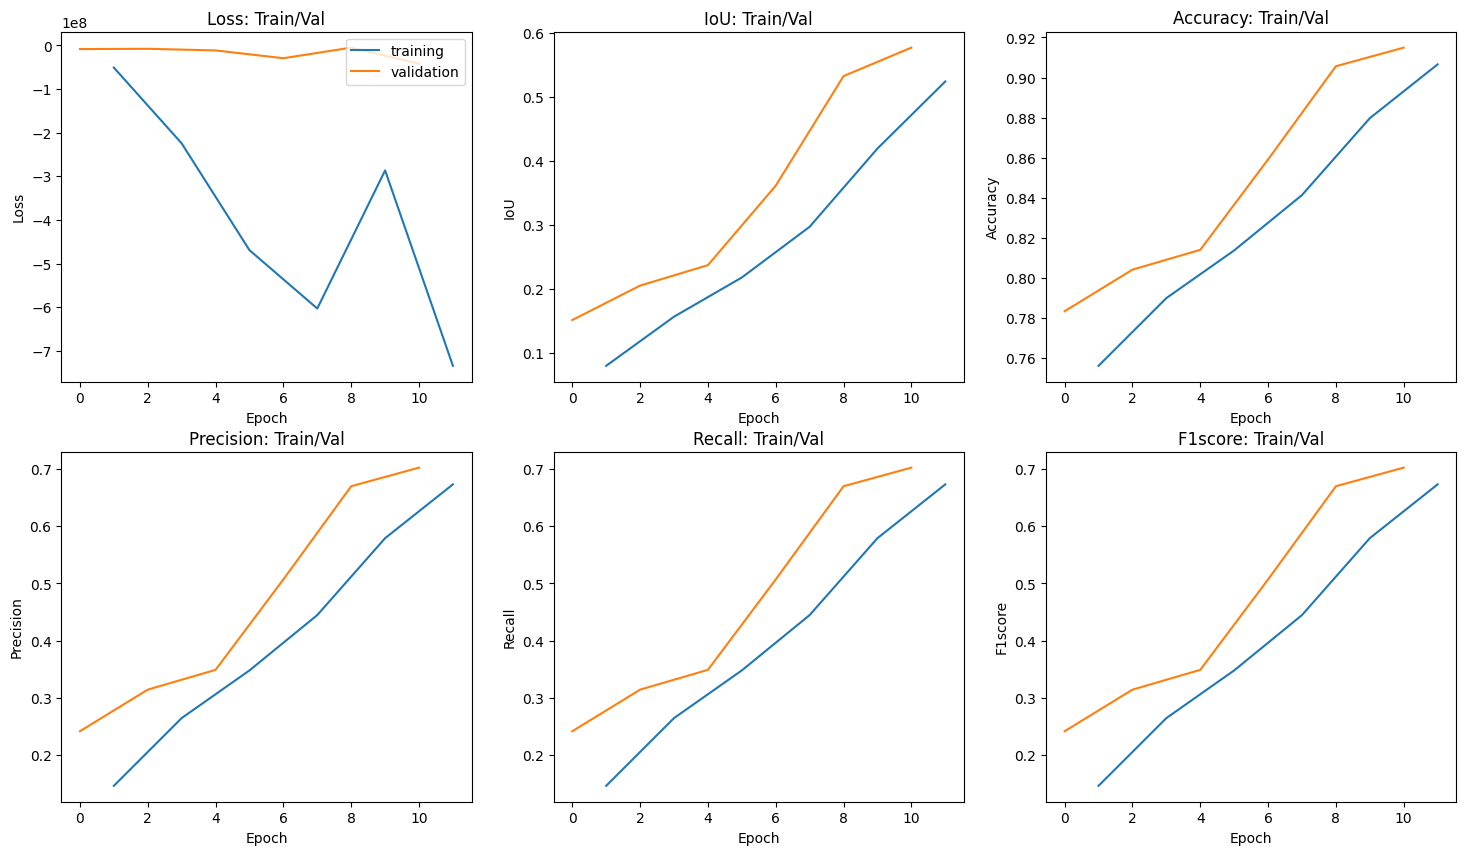

In [17]:
metrics = pd.read_csv("./lightning_logs/manet-log/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

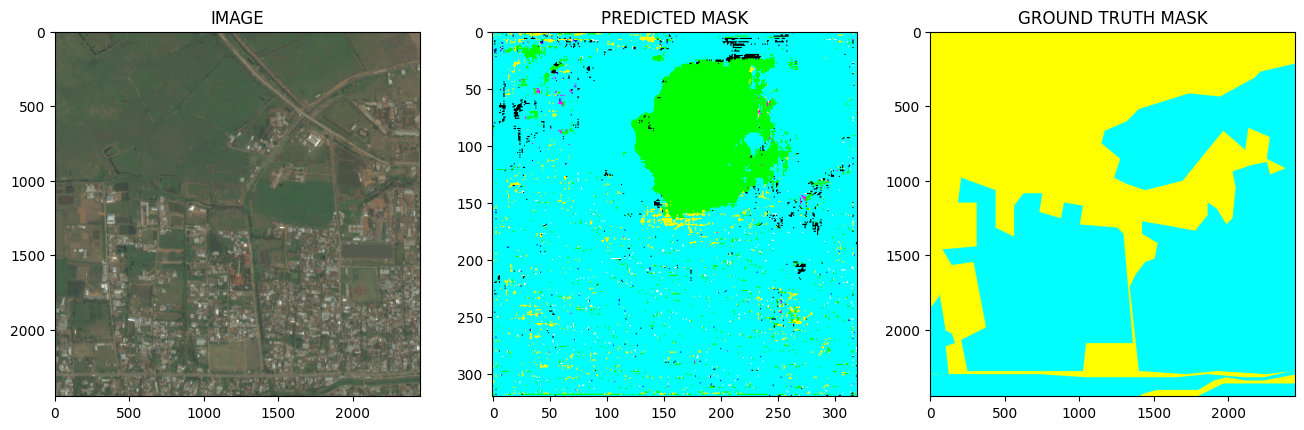

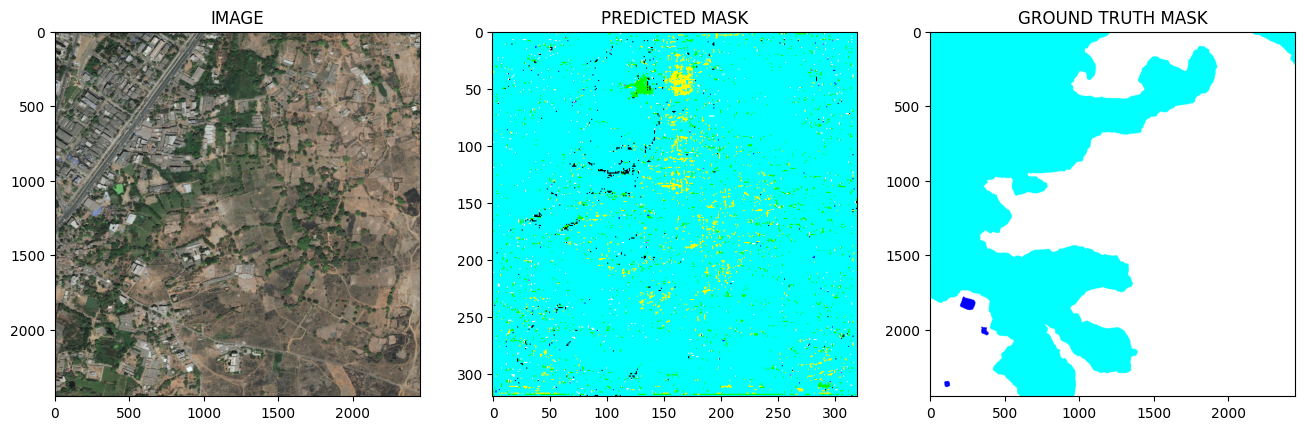

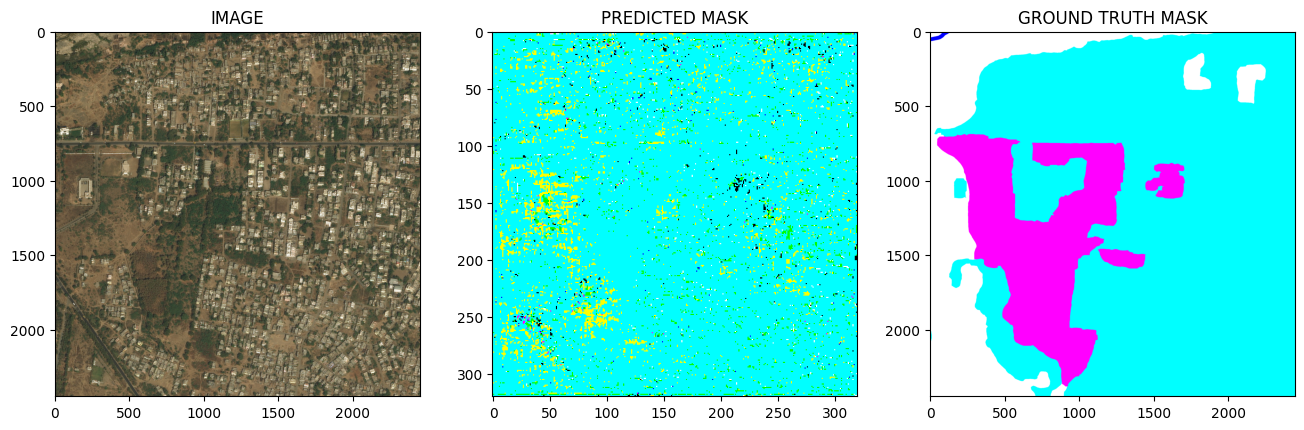

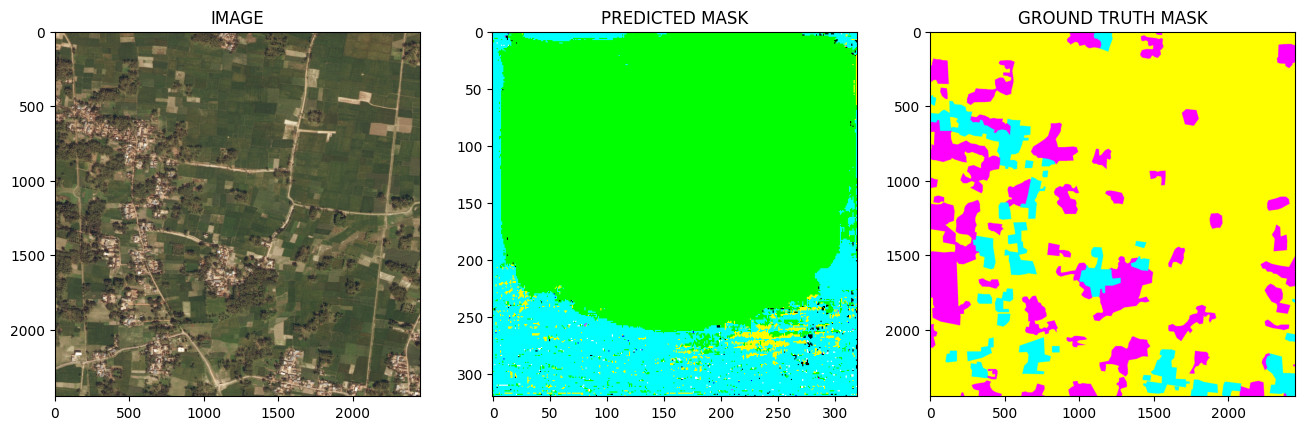

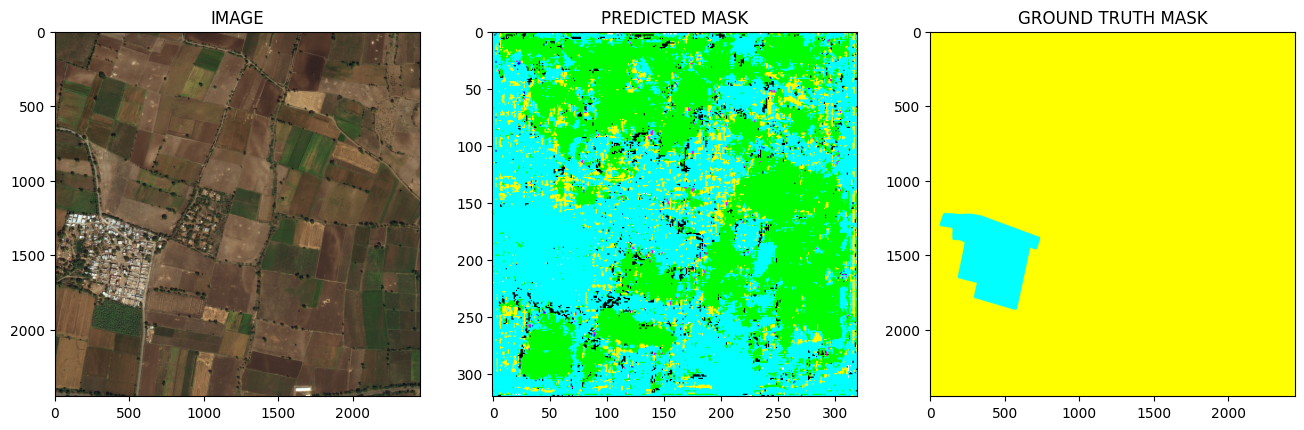

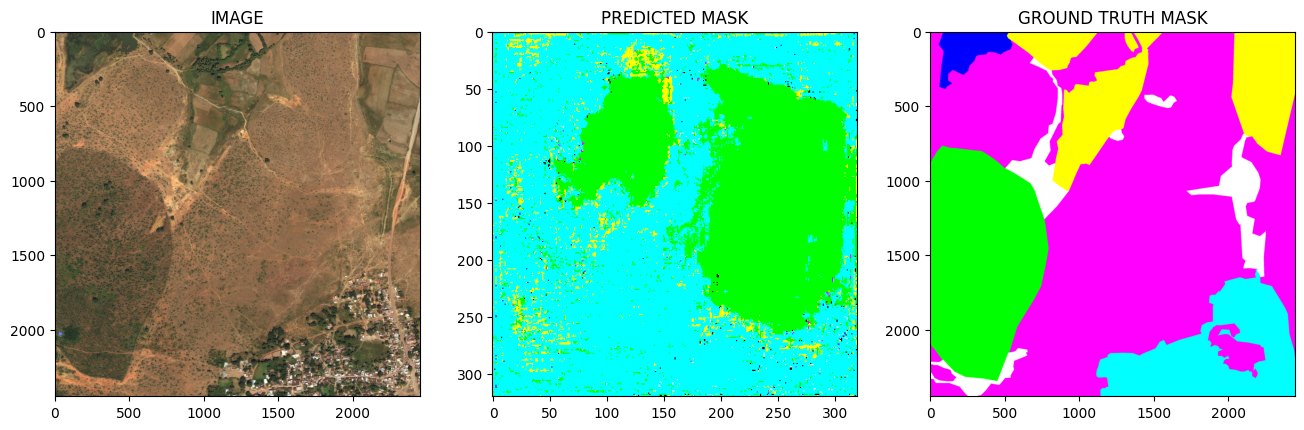

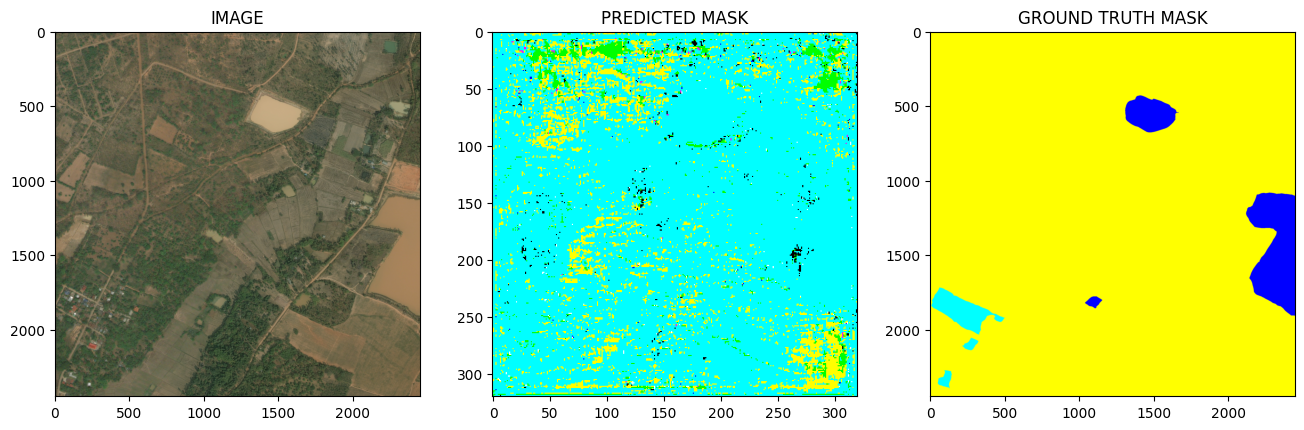

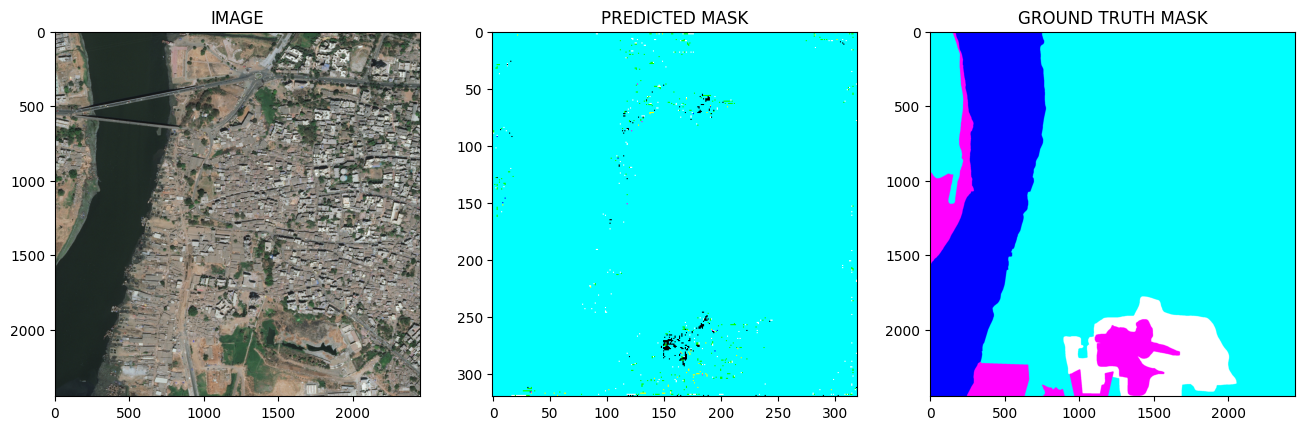

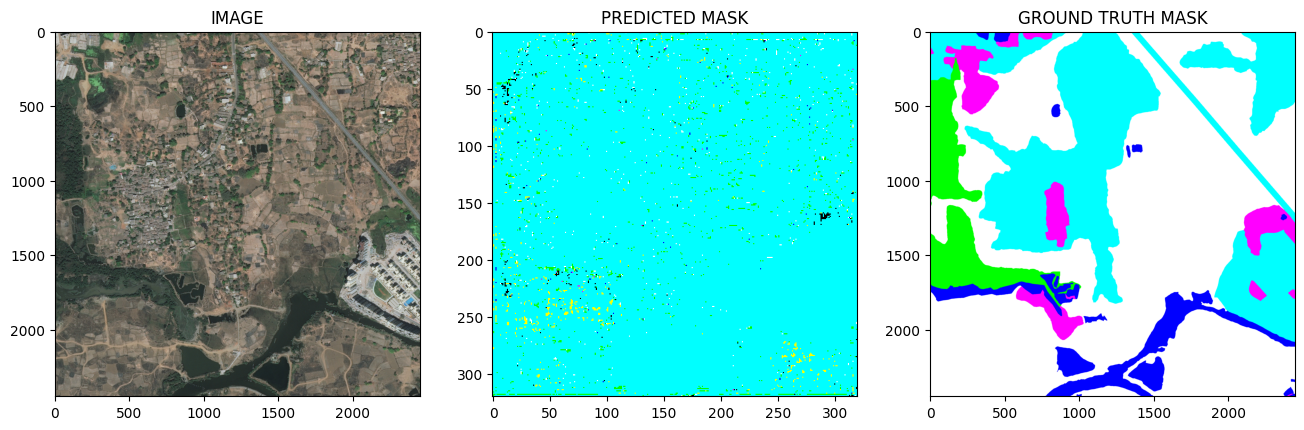

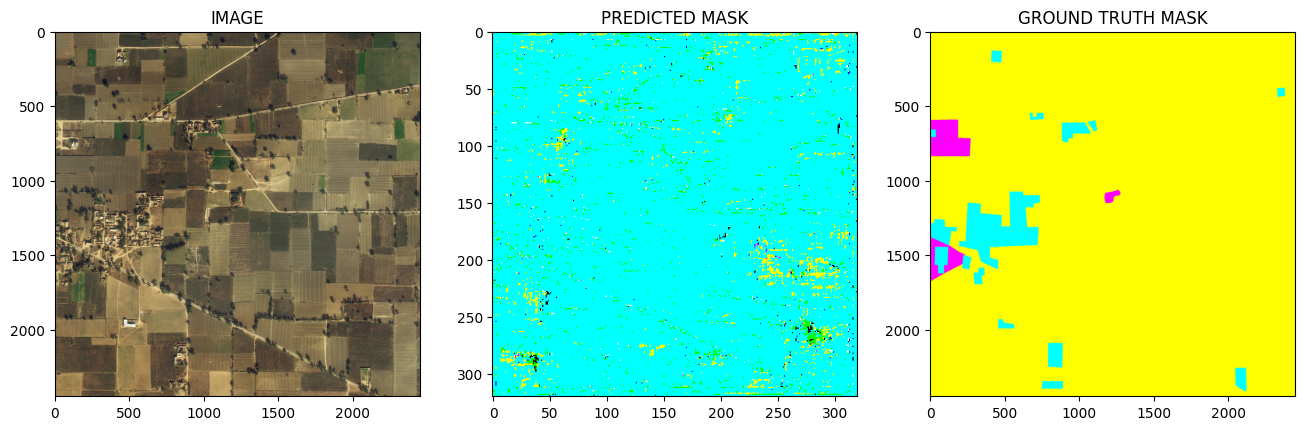

In [18]:
# Print ground truth mask and predicted mask
import random

sample = [random.randrange(len(pd_test)) for i in range(10)]

for index in sample:
    sample_img = cv2.imread(pd_test.iloc[index].IMAGES)
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    sample_msk = cv2.imread(pd_test.iloc[index].MASKS)
    sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

    image = cv2.resize(sample_img, (IMAGE_SIZE, IMAGE_SIZE))
    image = np.transpose(image, (2, 0, 1)).astype(np.float64)
    image = torch.Tensor(image) / 255.0
    image = image.unsqueeze(0)

    model.eval()
    outputs = model(image)
    outputs = outputs.argmax(dim=1).squeeze(0).detach().cpu().numpy()
    outputs = category2rgb(outputs)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))

    ax1.set_title('IMAGE')
    ax1.imshow(sample_img)

    ax2.set_title('PREDICTED MASK')
    ax2.imshow(outputs)

    ax3.set_title('GROUND TRUTH MASK')
    ax3.imshow(sample_msk)


plt.show()